In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import mlp
import nalu

In [3]:
def create_data(min_val, max_val, n_elts, fun_op, single_dim=False):
    if single_dim:
        x = torch.randint(low=min_val, high=max_val + 1, size=(n_elts, 1))
        y = fun_op(x).reshape(-1)
    else:
        x = torch.randint(low=min_val, high=max_val + 1, size=(n_elts, 2))
        y = fun_op(x[:, 0], x[:, 1])

    return x, y


def train(model, data, n_epochs, optimizer, lr, verbose=False):
    opt = optimizer(model.parameters(), lr=lr)
    x, y = data
    
    for epoch in range(n_epochs):
        pred = model(x).reshape(-1)
        mse = F.mse_loss(pred, y)
        mae = torch.mean(torch.abs(pred - y))
        
        opt.zero_grad()
        mse.backward()
        opt.step()
        
        if verbose and epoch % 10000 == 0:
            print(f'Epoch: {epoch}: mse={round(mse.item(), 2)}; mae={round(mae.item(), 2)}')
        
        
def test(model, data):
    x, y = data
    
    pred = model(x).reshape(-1)
    
    mse = F.mse_loss(pred, y)
    mae = torch.mean(torch.abs(pred - y))
    
    return round(mse.item(), 2), round(mae.item(), 2)

In [4]:
fun_dict = {
    'add': lambda x, y: x + y,
    'sub': lambda x, y: x - y,
    'mul': lambda x, y: x * y,
    'div': lambda x, y: x / y,
    'sqr': lambda x: torch.pow(x, 2),
    'sqrt': lambda x: torch.sqrt(x)
}

models = {
    'tanh': nn.Tanh,
    'sigmoid': nn.Sigmoid,
    'relu6': nn.ReLU6,
    'softsign': nn.Softsign,
    'selu': nn.SELU,
    'elu': nn.ELU,
    'relu': nn.ReLU,
    'none': None,
    'NAC': None,
    'NALU': None
}

In [5]:
N_LAYERS = 2
OUT_DIM = 1
HIDDEN_DIM = 2
N_EPOCHS = int(1e5)
OPTIMIZER = torch.optim.RMSprop
LR = 0.01
RANGE_INTER = (1, 100)
RANGE_EXTRA = (101, 200)
N_ELTS = 500

In [6]:
interpolation_logs = {}
extrapolation_logs = {}

for fun_name, fun_op in fun_dict.items():
    if fun_name in ['sqr', 'sqrt']:
        single_dim = True
        in_dim = 1
    else:
        single_dim = False
        in_dim = 2
        
    train_data = create_data(*RANGE_INTER, N_ELTS, fun_op, single_dim)
    test_data_interpolation = create_data(*RANGE_INTER, N_ELTS, fun_op, single_dim)
    test_data_extrapolation = create_data(*RANGE_EXTRA, N_ELTS, fun_op, single_dim)  
    
    interpolation_logs[fun_name] = {}
    extrapolation_logs[fun_name] = {}
    
    for model_name, act in models.items():
        if model_name == 'NAC':
            model = nalu.StackedNAC(N_LAYERS, in_dim, OUT_DIM, HIDDEN_DIM)
        elif model_name == 'NALU':
            model = nalu.StackedNALU(N_LAYERS, in_dim, OUT_DIM, HIDDEN_DIM)
        else:
            model = mlp.MLP(N_LAYERS, in_dim, OUT_DIM, HIDDEN_DIM, act)

        train(model, train_data, N_EPOCHS, OPTIMIZER, LR)
        _, mae_inter = test(model, test_data_interpolation)
        _, mae_extra = test(model, test_data_extrapolation)

        interpolation_logs[fun_name][model_name] = mae_inter
        extrapolation_logs[fun_name][model_name] = mae_extra

        print(f'{fun_name.ljust(10)}: {model_name.ljust(10)}: mae inter: {mae_inter}, mae extra: {mae_extra}')
        
        del model
    del train_data
    del test_data_interpolation
    del test_data_extrapolation

add       : tanh      : mae inter: 8.09, mae extra: 143.92
add       : sigmoid   : mae inter: 6.08, mae extra: 132.72
add       : relu6     : mae inter: 32.1, mae extra: 199.93
add       : softsign  : mae inter: 7.02, mae extra: 133.96
add       : selu      : mae inter: 1.1, mae extra: 3.3
add       : elu       : mae inter: 1.01, mae extra: 3.05
add       : relu      : mae inter: 1.0, mae extra: 2.95
add       : none      : mae inter: 0.36, mae extra: 1.03


/usr/local/lib/python3.6/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


add       : NAC       : mae inter: 0.1, mae extra: 0.28
add       : NALU      : mae inter: 0.0, mae extra: 0.0
sub       : tanh      : mae inter: 9.35, mae extra: 16.76
sub       : sigmoid   : mae inter: 6.86, mae extra: 14.98
sub       : relu6     : mae inter: 11.06, mae extra: 26.52
sub       : softsign  : mae inter: 7.35, mae extra: 10.45
sub       : selu      : mae inter: 1.64, mae extra: 4.71
sub       : elu       : mae inter: 1.39, mae extra: 3.99
sub       : relu      : mae inter: 1.53, mae extra: 3.75
sub       : none      : mae inter: 0.36, mae extra: 0.36
sub       : NAC       : mae inter: 0.08, mae extra: 0.08
sub       : NALU      : mae inter: 0.0, mae extra: 0.0
mul       : tanh      : mae inter: 997.66, mae extra: 19986.83
mul       : sigmoid   : mae inter: 1221.85, mae extra: 20981.24
mul       : relu6     : mae inter: 608.06, mae extra: 16777.79
mul       : softsign  : mae inter: 1819.15, mae extra: 20339.38
mul       : selu      : mae inter: 322.94, mae extra: 5430.98


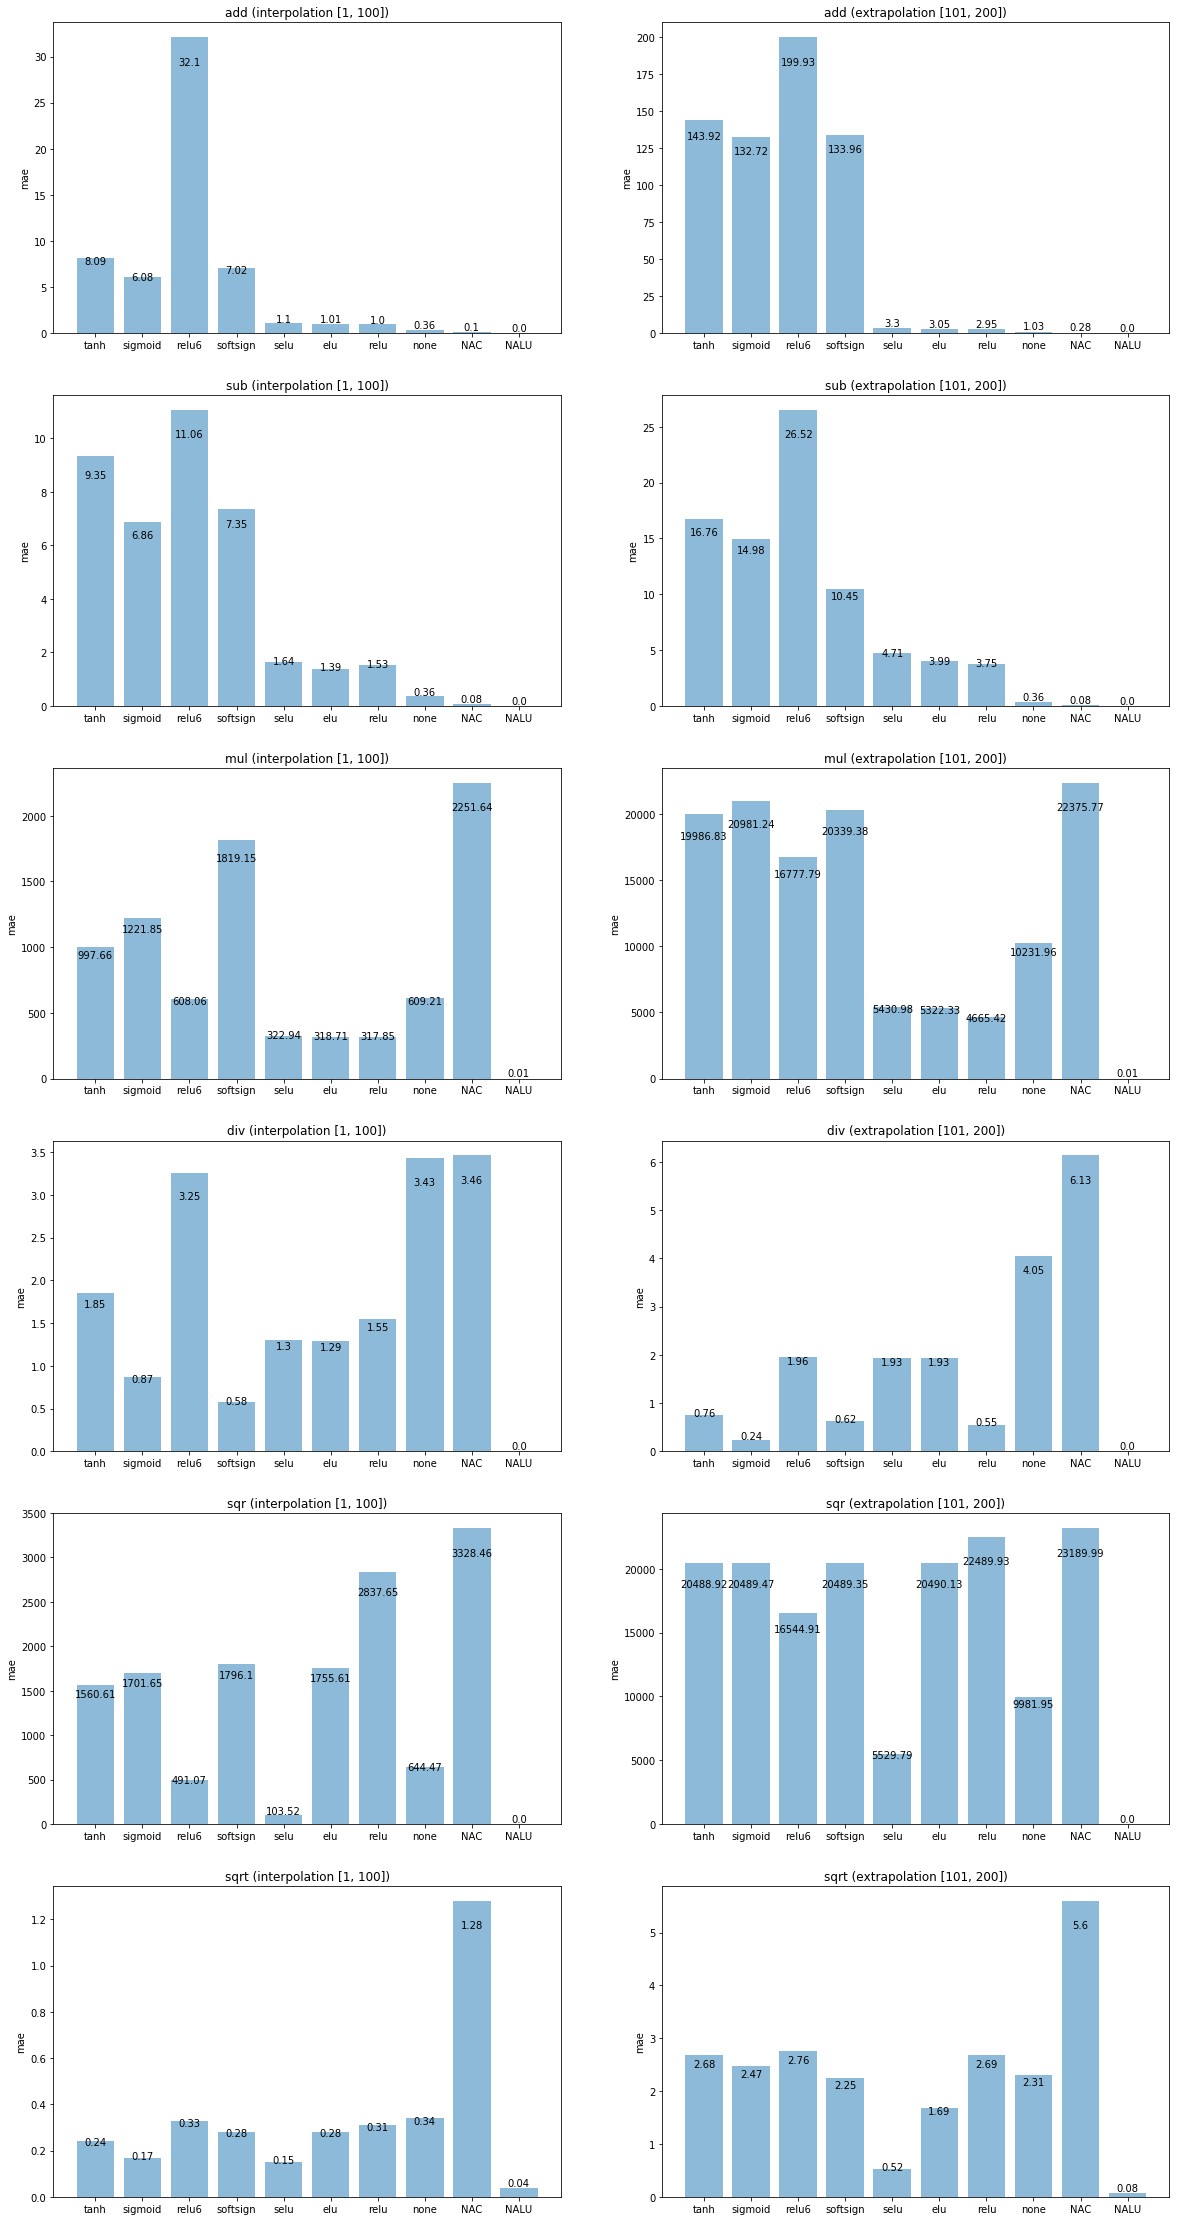

In [10]:
def autolabel(rects, ax):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2., 0.9 * height,
                str(height), ha='center', va='bottom')

idx = 1
n_rows = len(interpolation_logs.keys())
figure = plt.figure(figsize=(20, 40))

for fun_name in interpolation_logs.keys():
    ax1 = figure.add_subplot(n_rows, 2, idx)

    items = list(interpolation_logs[fun_name].keys())
    y_pos = np.arange(len(items))
    mae = list(interpolation_logs[fun_name].values())

    rect1 = ax1.bar(y_pos, mae, align='center', alpha=0.5)
    ax1.set_xticks(np.arange(len(items)))
    ax1.set_xticklabels(items)
    ax1.set_ylabel('mae')
    ax1.set_title(f'{fun_name} (interpolation [{RANGE_INTER[0]}, {RANGE_INTER[1]}])')
    autolabel(rect1, ax1)

    ax2 = figure.add_subplot(n_rows, 2, idx + 1)

    items = list(extrapolation_logs[fun_name].keys())
    y_pos = np.arange(len(items))
    mae = list(extrapolation_logs[fun_name].values())

    rect2 = ax2.bar(y_pos, mae, align='center', alpha=0.5)
    ax2.set_xticks(np.arange(len(items)))
    ax2.set_xticklabels(items)
    ax2.set_ylabel('mae')
    ax2.set_title(f'{fun_name} (extrapolation [{RANGE_EXTRA[0]}, {RANGE_EXTRA[1]}])')
    autolabel(rect2, ax2)
    
    idx += 2

plt.show()